## Final Project: LSH Plagiarism Checker
## CS-UY 3943: Mining Massive Dataset  
Zachary Zeng # `nz900`  
Simon Men # `jm7828`

#### File Descriptions

* `requirements.txt` includes the names of the packages used in the project, you may run the cell beblow to install them.

In [5]:
%pip install -r "requirements.txt"

* `file_info.csv` is a table including the informationa about the texts 
* `source/` contains the source(original) texts in the dataset
* `test/` contains the suspicious texts in the dataset

### Problem description adnd Hypotheis
In this project, we are trying to use **Locality Sensitivity Hashing** and **MinHash** to identify plagiarism based on content similarity. Note that, the plagiarism works we are trying to identify in this case are mostly exact copy and paste without parahpraseing, since other deep learning models are able to detect plagiarism with paraphraseing and word replacements. In our case, given a set of source documents and a set of suspicious documents which include varying amount of contents from source documents, the model performs a binary classification on if the suspicious document contains plagiarism. 

In [33]:
import os
from glob import glob
import numpy as np
import pandas as pd

In [13]:
DATA_SOURCE = "./source"
SUSPICIOUS_DOCS = "./test"
FILE_INFO = "file_info.csv"

### Dataset Description


The dataset was created by Paul Clough from the University of Sheffield: _A Corpus of Plagiarized Short Answers_  (The original link for download has expired, but we found an alternative source https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip).    
The corpus includes a set of short answers on 5 different questions related to computer science.  
The responses includes varying amount of plagiarized texts and Wikipedia.  
The sources are also included, named as `orig_task*.txt`, where the letter following task indicates the questions corresponding to the answers.  
The following cells include some preliminary informations about the data.


In [14]:
pd.read_csv(FILE_INFO)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
...,...,...,...
95,orig_taska.txt,a,orig
96,orig_taskb.txt,b,orig
97,orig_taskc.txt,c,orig
98,orig_taskd.txt,d,orig


The `Category` indicates the degree of plagiarism

In [15]:
glob(os.path.join(DATA_SOURCE, '*.txt')), glob(os.path.join(SUSPICIOUS_DOCS, '*.txt'))

(['./source/orig_taskd.txt',
  './source/orig_taske.txt',
  './source/orig_taska.txt',
  './source/orig_taskb.txt',
  './source/orig_taskc.txt'],
 ['./test/g0pC_taskc.txt',
  './test/g0pE_taskd.txt',
  './test/g0pE_taske.txt',
  './test/g0pC_taskb.txt',
  './test/g1pA_taske.txt',
  './test/g3pB_taskd.txt',
  './test/g3pB_taske.txt',
  './test/g0pC_taska.txt',
  './test/g1pA_taskd.txt',
  './test/g0pC_taske.txt',
  './test/g3pB_taska.txt',
  './test/g0pE_taskb.txt',
  './test/g0pE_taskc.txt',
  './test/g0pC_taskd.txt',
  './test/g1pA_taska.txt',
  './test/g1pA_taskc.txt',
  './test/g3pB_taskb.txt',
  './test/g0pE_taska.txt',
  './test/g3pB_taskc.txt',
  './test/g1pA_taskb.txt',
  './test/g2pA_taskb.txt',
  './test/g0pD_taskd.txt',
  './test/g0pB_taskc.txt',
  './test/g0pB_taskb.txt',
  './test/g0pD_taske.txt',
  './test/g2pA_taskc.txt',
  './test/g3pC_taskd.txt',
  './test/g2pA_taska.txt',
  './test/g0pB_taska.txt',
  './test/g3pC_taske.txt',
  './test/g3pC_taska.txt',
  './test/g2pA_ta

### Preprocessing

In [17]:
import nltk
import codecs
from nltk.tokenize import wordpunct_tokenize

def read_file(file_name: str) -> str:
    """
    Read text files to strings by different encoding modes in case of exception
    """
    try:
        text = codecs.open(file_name).read()
    except UnicodeDecodeError:
        text = codecs.open(file_name, encoding='cp1252').read()
    except FileNotFoundError:
        text = ""
    return text

def create_dataset_df(file_info: str, docs_dir: str) -> pd.DataFrame:
    """
    Creates a Pandas dataframe from file info, with cells with text content and binary labels on if the text includes plagiarism
    """
    df = pd.read_csv(file_info)
    df['Text'] = np.array([read_file(os.path.join(docs_dir, file)) for file in df["File"]])
    df["Label"] = (df["Category"]!="non")
    df = df[df["Category"]!="orig"]
    df = df.drop(columns=['Category'])
    return df

In [18]:
data_df = create_dataset_df(FILE_INFO, SUSPICIOUS_DOCS)
data_df

,File,Task,Text,Label
0,g0pA_taska.txt,a,Inheritance is a basic concept of Object-Orien...,False
1,g0pA_taskb.txt,b,PageRank is a link analysis algorithm used by ...,True
2,g0pA_taskc.txt,c,"The vector space model (also called, term vect...",True
3,g0pA_taskd.txt,d,Bayes’ theorem was names after Rev Thomas Baye...,True
4,g0pA_taske.txt,e,Dynamic Programming is an algorithm design tec...,False
...,...,...,...,...
90,g4pE_taska.txt,a,Object oriented programming is a style of pro...,True
91,g4pE_taskb.txt,b,PageRankalgorithm is also known as link analys...,True
92,g4pE_taskc.txt,c,The definition of term depends on the applicat...,True
93,g4pE_taskd.txt,d,"""Bayes' Theorem"" or ""Bayes' Rule"", or somethin...",False


Sample suspicious text

In [62]:
print(data_df.iloc[1]["Text"]) 

PageRank is a link analysis algorithm used by the Google Internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set. Google assigns a numeric weighting from 0-10 for each webpage on the Internet; this PageRank? denotes a site’s importance in the eyes of Google.

The PageRank? is derived from a theoretical probability value on a logarithmic scale like the Richter Scale. The PageRank? of a particular page is roughly based upon the quantity of inbound links as well as the PageRank? of the pages providing the links. The algorithm may be applied to any collection of entities with reciprocal quotations and references. The numerical weight that it assigns to any given element E is also called the PageRank? of E and denoted by PR(E).

It is known that other factors, e.g. relevance of search words on the page and actual visits to the page reported 

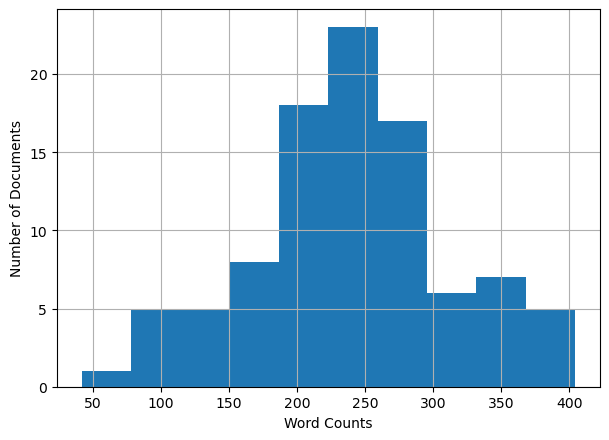

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["figure.dpi"] = 100
plt.grid()
word_counts = np.array([len(wordpunct_tokenize(text))for text in data_df["Text"]])
plt.hist(word_counts)
plt.xlabel("Word Counts")
plt.ylabel("Number of Documents")
plt.show()

In [21]:
print(f"""Average Word Counts:\t{np.average(word_counts).round(2)}
Standard Deviation:\t{np.std(word_counts).round(2)}""")

Average Word Counts:	239.56
Standard Deviation:	75.01


In [32]:
print(f"Positive samples: {np.sum((y==True).astype(int))} \nNegative samples: {np.sum((y==False).astype(int))}")

Positive samples: 57 
Negative samples: 38


### LSH Model Creation
We used the API in a package called `datasketch` to build our model.  
* `MinHash` is an instance from the package that hold the minimal hash values of a set strings, given a number of permutations.  
* `create_minhash` takes a string text, removes it puncutations, tokenize it in n grams, and feed them to a new `MinHash` instance.    
* `create_lsh` reads the texts in the source directory, creates their MinHash and update them to a new `MinHashLSH` model given its jaccard similarity threshold and number of permutations.  

In [22]:
from datasketch import MinHash, MinHashLSH

def create_minhash(text: str, n_gram: int, num_perm=128) -> MinHash:
    """
    Tokenize text in N-grams, removes punctuations, and generates minhash from a text given ngrams and number of permutations
    """
    tokens = wordpunct_tokenize(text)
    minhash = MinHash(num_perm=num_perm)
    for gram in nltk.ngrams(tokens, n_gram):
        minhash.update(" ".join(gram).encode('utf-8')) 
    return minhash

def create_lsh(source_dir: str, threshold=.3, n_gram=3, num_perm=128) -> MinHashLSH:
    """
    Create an LSH instance from text files in source directory given threshold, n-grams, and number of permutation
    Returns an LSH object and a list of key indicates the source files
    """
    lsh = MinHashLSH(num_perm=num_perm, threshold=threshold)
    file_names = glob(os.path.join(source_dir, '*.txt'))
    file_names.sort()
    keys = []
    minhashes = []
    for fname in file_names:
        text = read_file(fname)
        minhash = create_minhash(text, n_gram, num_perm=num_perm)
        keys.append(os.path.basename(fname))
        minhashes.append(minhash)
    with lsh.insertion_session() as session:
        for key, minhash in zip(keys, minhashes):
            session.insert(key, minhash)
    return lsh, keys

def add_lsh_source(lsh: MinHashLSH, text: str, key: str, n_gram: int, num_perm: int):
    """
    Add additional source texts to an existant LSH model, this can be used during deployment update 
    """
    minhash = create_minhash(text, n_gram, num_perm)
    lsh.insert(key, minhash)
    return

### Model Methods
Our model works by creating a `MinHashLSH` instance that holds the minhashes of the source texts.  
When a suspicious document is evaluted by the model, model compares their minhashes, calculates their jaccard similarity, and returns if the similarity is above the model's threshold.

In [34]:
def eval_single(lsh: MinHashLSH, text: str, n_gram: int, num_perm=128) -> bool:
    """
    Evaluate a single text to a MinHashLSH instance given number of grams and permutations
    """
    minhash = create_minhash(text, n_gram, num_perm=num_perm)
    keys = lsh.query(minhash)
    return len(keys)>0

def eval_list(lsh: MinHashLSH, texts: np.array, n_gram: int, num_perm: int)-> np.array:
    """
    Given an array of texts, return a boolean array of binary classification
    """
    results = []
    for text in texts:
        result = eval_single(lsh, text, n_gram, num_perm=num_perm)
        results.append(result)
    return np.array(results)

### Model Deployment
The model can also be saved and reload for deployment

In [39]:
import pickle
def save_lsh(model: MinHashLSH, file_dir: str):
    """
    Save the LSH model to a given directory in binary format using pickle
    """
    with open(file_dir, 'wb+') as file:
        pickle.dump(model, file)
    return

def load_lsh(model_dir: str) -> MinHashLSH:
    """
    Load a pickled LSH model to memory
    """
    try:
        with open(model_dir, 'r') as file:
            return pickle.load(file)
    except:
        print(f"Model: {model_dir} doesn't exist or in unsupported format!")

### Testing and Evalutation
Testing the model with default parameters and calculating relevant metrics for true and predicted binary output result.

In [52]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

In [59]:
X = data_df["Text"].values
y = data_df["Label"].values
n_gram = 3
jaccard_th = .1
num_perm = 128
lsh, keys = create_lsh(DATA_SOURCE, jaccard_th, n_gram, num_perm)
y_pred = eval_list(lsh, X, n_gram, num_perm)

In [64]:
print(f"\nAccuracy: {accuracy_score(y, y_pred)}, \nRecall: {recall_score(y, y_pred)}, \nPrecision: {precision_score(y, y_pred)}, \nF1 score: {f1_score(y, y_pred)}")


Accuracy: 0.8105263157894737, 
Recall: 0.6842105263157895, 
Precision: 1.0, 
F1 score: 0.8125000000000001


The preliminary Accuracy for this model is acceptable. Note that the precision is 1, meaining there is no false positive sample. This is explainable by the nature of LSH and the current sample size.

#### Evaluating the effects of different preprocessing techniques: n-grams

In [69]:
jaccard_th = .1
num_perm = 128
for n_gram in range(1, 11):
    lsh, keys = create_lsh(DATA_SOURCE, n_gram=n_gram, threshold=jaccard_th, num_perm=num_perm)
    results = eval_list(lsh, X, n_gram, num_perm)
    print(f'{n_gram} grams, accuracy: {accuracy_score(y, results).round(2)} \tF1 score: {f1_score(y, results)}')


1 grams, accuracy: 0.62 	F1 score: 0.76
2 grams, accuracy: 0.85 	F1 score: 0.8793103448275862
3 grams, accuracy: 0.81 	F1 score: 0.8125000000000001
4 grams, accuracy: 0.77 	F1 score: 0.7608695652173912
5 grams, accuracy: 0.76 	F1 score: 0.7472527472527472
6 grams, accuracy: 0.74 	F1 score: 0.7191011235955056
7 grams, accuracy: 0.68 	F1 score: 0.6428571428571429
8 grams, accuracy: 0.65 	F1 score: 0.5925925925925926
9 grams, accuracy: 0.67 	F1 score: 0.6265060240963854
10 grams, accuracy: 0.66 	F1 score: 0.6097560975609756


According to the accuracy scores, 2, 3 grams tokenization best captures the essential information from the texts. While 1 gram doesn't necessarily captures the sequence of words and produces more false positves, higher grams (> 5) are too sparse 

#### Changing Jaccard Similarity Threshold

In [70]:
n_gram = 3
num_perm = 128
for jaccard_th in [.001, .01, .05, .1, .2]:
    lsh, keys = create_lsh(DATA_SOURCE, n_gram=n_gram, threshold=jaccard_th, num_perm=num_perm)
    results = eval_list(lsh, X, n_gram, num_perm)
    print(f'jaccard similarity: {jaccard_th}, accuracy: {accuracy_score(y, results).round(2)} \tF1 score: {f1_score(y, results)}')


jaccard similarity: 0.001, accuracy: 0.63 	F1 score: 0.7651006711409396
jaccard similarity: 0.01, accuracy: 0.63 	F1 score: 0.7651006711409396
jaccard similarity: 0.05, accuracy: 0.8 	F1 score: 0.8527131782945737
jaccard similarity: 0.1, accuracy: 0.81 	F1 score: 0.8125000000000001
jaccard similarity: 0.2, accuracy: 0.75 	F1 score: 0.7333333333333334


Jaccard similarity between suspicious docs and sources with 3 gram tokenization is around 0.05 to 0.1 in this case

#### Effects of number of permutation buckets

In [77]:
accs = []
jaccard_th = .1
n_gram = 3
perms = np.arange(2, 256, 10)
for num_perm in perms:
    lsh, keys = create_lsh(DATA_SOURCE, n_gram=n_gram, threshold=jaccard_th, num_perm=num_perm)
    results = eval_list(lsh,X, n_gram, num_perm)
    accs.append(accuracy_score(y, results))

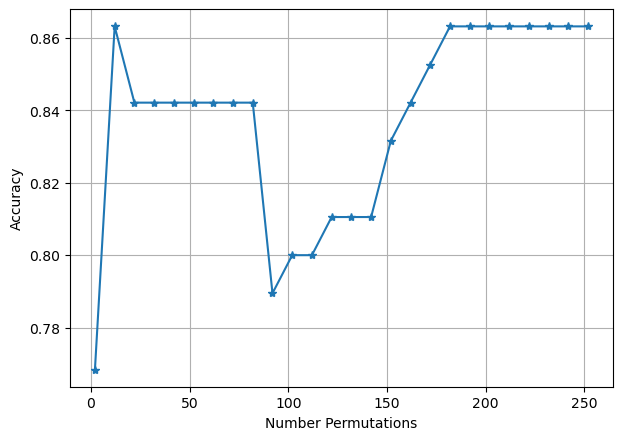

In [78]:
plt.plot(perms, accs, '-*')
plt.xlabel("Number Permutations")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

For this dataset with 3 grams, the accuracy score for the model has a local minimum with around 80 permutations

#### Final Report
* Detailed description your models
    * Describe what kinds of statistical methods and machine learning algorithms you used
    * How did you validate your models?
    * What other models did you consider, and why didn't you proceed with those?
    * Some suggested keywords are regression, classification, recommendations, cross-validation,
    overfitting, etc.
* What business applications do your findings have?
* Optionally, describe how your analyses would be implemented in a live system (e.g., a personal
recommendation system or a tweetbot). Where would the data live, how would you represent your
results, how would end-users access it? When would your model learn new parameters? Describe in
detail the pipeline from data ingestion to end-user experience